c:\Python311\Lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Python311\Lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	4     
1  	4     
2  	2     
3  	2     
4  	2     
5  	3     


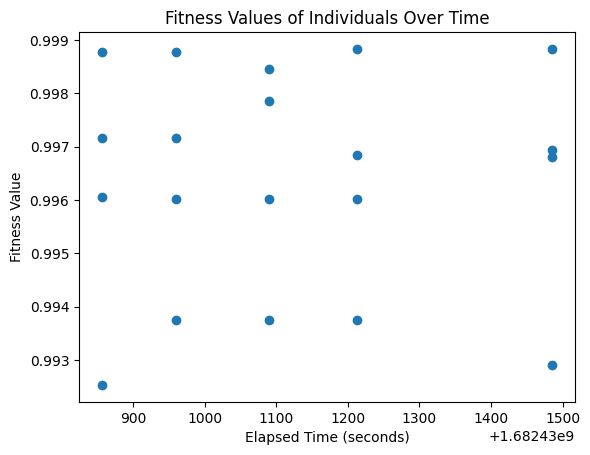

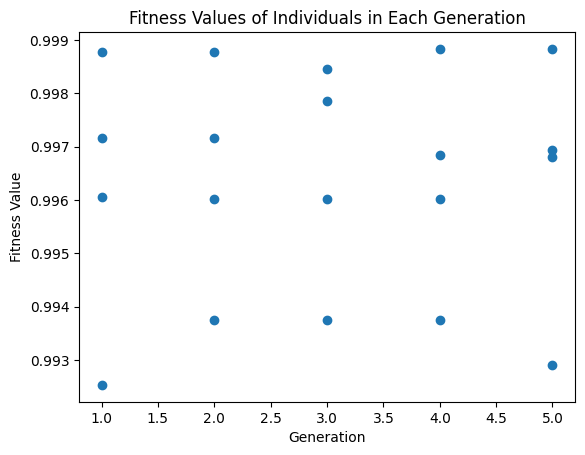

Epoch 1/10
46/46 [==============================] - 27s 192ms/step - loss: 0.0206
Epoch 2/10
46/46 [==============================] - 9s 194ms/step - loss: 0.0014
Epoch 3/10
46/46 [==============================] - 9s 196ms/step - loss: 0.0013
Epoch 4/10
46/46 [==============================] - 9s 188ms/step - loss: 0.0012
Epoch 5/10
46/46 [==============================] - 9s 191ms/step - loss: 9.9647e-04
Epoch 6/10
46/46 [==============================] - 8s 174ms/step - loss: 0.0014
Epoch 7/10
46/46 [==============================] - 7s 153ms/step - loss: 0.0014
Epoch 8/10
46/46 [==============================] - 7s 142ms/step - loss: 0.0014
Epoch 9/10
46/46 [==============================] - 7s 153ms/step - loss: 0.0010
Epoch 10/10
12/12 [==============================] - 3s 47ms/step


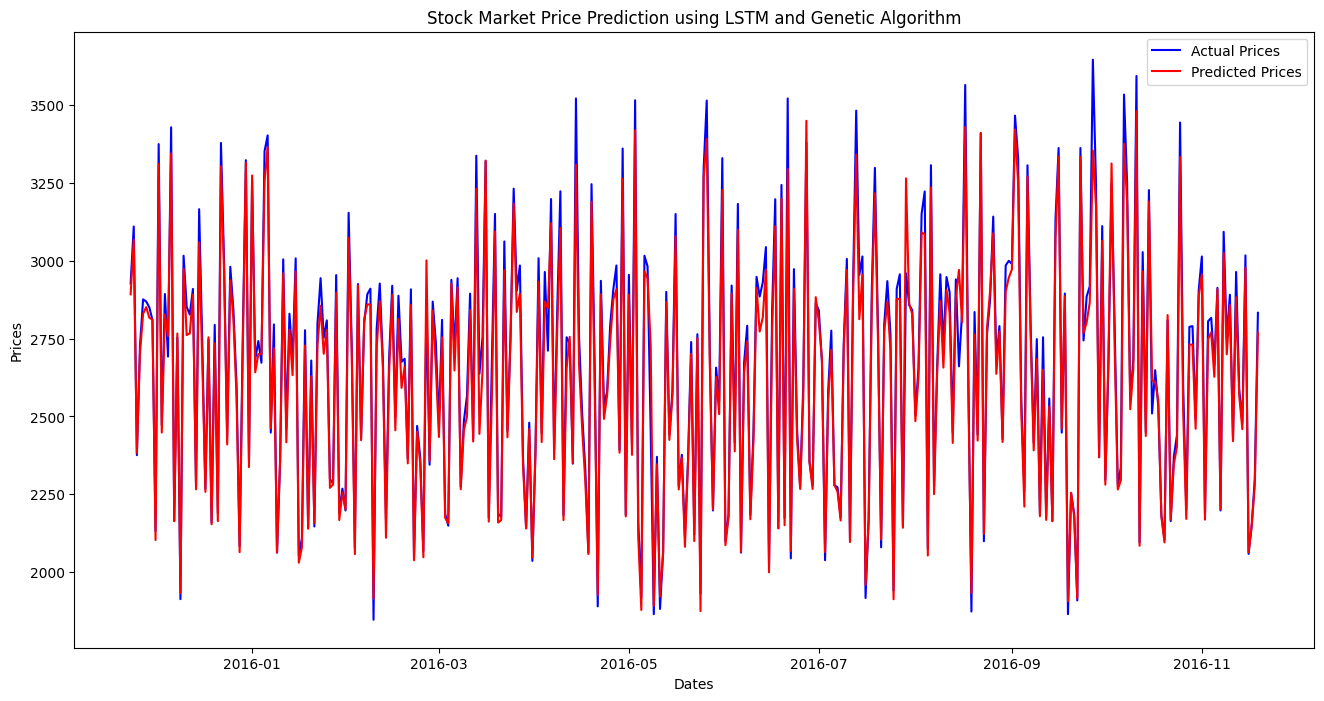

In [2]:
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random
from sklearn.model_selection import train_test_split
import time

# Load the stock market data (replace with your own data source)
data = pd.read_csv('stock_prices.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.values)

# Prepare the data for LSTM


def prepare_data(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)


look_back = 10  # Choose the number of previous time steps to use as input
X, y = prepare_data(data_scaled, look_back)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

input_shape = (X_train.shape[1], X_train.shape[2])


def create_lstm_model(units, dropout_rate, input_shape):
    model = Sequential()
    model.add(LSTM(units=int(units), return_sequences=True,
              input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=int(units), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=int(units)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Define the evaluation function


def evaluate_lstm(individual, X_train, y_train, input_shape):
    model = create_lstm_model(individual[0], individual[1], input_shape)
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    loss = history.history['loss'][-1]
    return (1 / (1 + loss),)


# Set up the genetic algorithm
creator.create('FitnessMax', base.Fitness, weights=(1.0,))
creator.create('Individual', list, fitness=creator.FitnessMax)

# Define the custom mutation function


def custom_mutation(individual, indpb_units=0.1, indpb_dropout_rate=0.1):
    if random.random() < indpb_units:
        individual[0] = toolbox.units()
    if random.random() < indpb_dropout_rate:
        individual[1] = toolbox.dropout_rate()
    return individual,


toolbox = base.Toolbox()
toolbox.register('units', random.randint, 10, 200)
toolbox.register('dropout_rate', random.uniform, 0, 1)
toolbox.register('individual', tools.initCycle, creator.Individual,
                 (toolbox.units, toolbox.dropout_rate), n=1)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register('mate', tools.cxOnePoint)
toolbox.register('mutate', custom_mutation,
                 indpb_units=0.1, indpb_dropout_rate=0.1)
toolbox.register('select', tools.selBest)
toolbox.register('evaluate', evaluate_lstm, X_train=X_train,
                 y_train=y_train, input_shape=input_shape)

population = toolbox.population(n=4)  # Number of individuals
ngen = 5  # Number of generations


def store_fitness_values(population, generation, fitness_values, generations, elapsed_times):
    for ind in population:
        fitness_values.append(ind.fitness.values[0])
        generations.append(generation)
        elapsed_times.append(time.time())


def eaSimpleWithFitnessStorage(population, toolbox, cxpb, mutpb, ngen, stats=None,
                               halloffame=None, verbose=__debug__, fitness_values=None, generations=None, elapsed_times=None):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the old population by the offspring
        population[:] = offspring

        # Store the fitness values and generations
        if fitness_values is not None and generations is not None:
            store_fitness_values(population, gen, fitness_values, generations,elapsed_times)

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook


fitness_values = []
generations = []
elapsed_times = []


result, log = eaSimpleWithFitnessStorage(
    population, toolbox, cxpb=0.5, mutpb=0.2, ngen=ngen, verbose=True,
    fitness_values=fitness_values, generations=generations, elapsed_times=elapsed_times)

elapsed_times = [t  for t in elapsed_times]


plt.scatter(elapsed_times, fitness_values)
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Fitness Value')
plt.title('Fitness Values of Individuals Over Time')
plt.show()


plt.scatter(generations, fitness_values)
plt.xlabel('Generation')
plt.ylabel('Fitness Value')
plt.title('Fitness Values of Individuals in Each Generation')
plt.show()


best_individual = tools.selBest(population, 1)[0]
best_model = create_lstm_model(
    best_individual[0], best_individual[1], input_shape)
history = best_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

predicted_prices_scaled = best_model.predict(X_test)

predicted_prices_array = np.zeros(
    shape=(len(predicted_prices_scaled), data_scaled.shape[1]))

predicted_prices_array[:, 0] = predicted_prices_scaled.ravel()

predicted_prices = scaler.inverse_transform(predicted_prices_array)[:, 0]

actual_prices_array = np.zeros(shape=(len(y_test), data_scaled.shape[1]))

actual_prices_array[:, 0] = y_test.ravel()

actual_prices = scaler.inverse_transform(actual_prices_array)[:, 0]

y_test_df = pd.DataFrame(y_test, columns=['Price'])
test_indices = data.index[y_test_df.index]


def plot_predictions(test_dates, actual_prices, predicted_prices):
    plt.figure(figsize=(16, 8))
    plt.plot(test_dates, actual_prices, color='blue', label='Actual Prices')
    plt.plot(test_dates, predicted_prices,
             color='red', label='Predicted Prices')
    plt.xlabel('Dates')
    plt.ylabel('Prices')
    plt.title('Stock Market Price Prediction using LSTM and Genetic Algorithm')
    plt.legend()
    plt.show()

plot_predictions(test_indices, actual_prices, predicted_prices)
    




 